In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import torch
import numpy as np
from pprint import pprint
import pathlib as pl
import torchaudio
import whisper
import torch.nn as nn

import matplotlib.pyplot as plt
from IPython.display import Audio

from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import (
    LlamaTokenizer,
    MistralConfig,
    MistralForCausalLM,
)
import torch
from torch.utils.data import DataLoader
import pathlib as pl

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, GenerationConfig

import torch
torch.backends.cuda.matmul.allow_tf32 = True

from src2.voixdb import util
from src2.voixdb.util import *
from src2.voixdb.dataset.music_caps import (
    MusicCapsDataset,
    load_csv,
)
from src2.voixdb.model import Model, TunableWhisperAudioEncoder, load_llm
from src2.voixdb.train import Trainer
from src2.voixdb.train_cfg import TrainerCfg


In [3]:
# !pip install datasets

In [4]:
# import whisper

# import torch
# from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
# from datasets import load_dataset


# device = "cuda:0" if torch.cuda.is_available() else "cpu"
# torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# model_id = "openai/whisper-large-v3"

# model = AutoModelForSpeechSeq2Seq.from_pretrained(
#     model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
# )
# model.to(device)

In [5]:
# from tqdm import tqdm
# with torch.no_grad():
#     with torch.amp.autocast(device_type="cuda",dtype=torch.float16):
#             [audio_encoder(util.load_audio_mels(entry["file"]).cuda()).cpu() for entry in tqdm(train_entries)]

In [6]:
# Access the values of the arguments
tr_cfg = TrainerCfg(
    epoch=1,
    model_save_freq=1,
    device="cuda:0",
    model_out_dir="/root/out-model",
)

class DummyEncoder(nn.Module):
    a=1
whisper_encoder = DummyEncoder() # set to None to auto-load it.

audio_encoder = TunableWhisperAudioEncoder(audio_encoder=whisper_encoder) # it's not None, but I don't wanna load a heavy encoder
# audio_encoder.load_state_dict(torch.load("model_manual_save3.pth"))

audio_encoder.to(tr_cfg.device)

tokenizer,llm = load_llm()
model = Model(audio_encoder.to(torch.bfloat16), llm)

entries = load_csv(load_raw=False)
train_size = int(len(entries) * 0.9)
train_entries = entries[:train_size]
eval_entries = entries[train_size:]

max_length = 400

embed_tokens = model.llm.model.embed_tokens
torch.save(embed_tokens.state_dict(),"embed.pt")
raw_embedding = nn.Embedding(embed_tokens.num_embeddings,embed_tokens.embedding_dim)
raw_embedding.load_state_dict(embed_tokens.state_dict())
raw_embedding.cpu()

eval_ds = MusicCapsDataset(eval_entries, tokenizer, util.prompt_template_fn,audio_encoder.audio_encoder,raw_embedding,max_length,key="eval-audio")
eval_dl = DataLoader(eval_ds, batch_size=2, shuffle=True, num_workers=6)

train_ds = MusicCapsDataset(train_entries, tokenizer, util.prompt_template_fn,audio_encoder.audio_encoder,raw_embedding,max_length,key="train-audio")
train_dl = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=12)



RuntimeError: Error(s) in loading state_dict for TunableWhisperAudioEncoder:
	Missing key(s) in state_dict: "proj.proj.weight", "proj.ln1.weight", "proj.ln1.bias". 
	Unexpected key(s) in state_dict: "ln1.weight", "ln1.bias", "proj.weight". 

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# counts, bins = np.histogram(list(train_ds.raw_sizes))
# plt.stairs(counts, bins)

In [ ]:
# verify model weight
from collections import Counter
pbytype = Counter()
for name, p in (model.named_parameters()):
    if torch.isinf(p).any() or torch.isnan(p).any():
        print(name, p)
        raise ValueError("invalid weight")
    else:
        pbytype[p.dtype] += 1
print("OK", pbytype)

OK Counter({torch.uint8: 224, torch.float16: 67, torch.bfloat16: 3})


In [ ]:
# means = []
# stds = []
# norms = []
# for name, p in (model.audio_encoder.audio_encoder.named_parameters()):
#     if p.dim() == 2:
#         print(p.dtype)
#         print(p.max().item(), p.min().item())

#         means.append(p.mean().item())
#         stds.append(p.std().item())
#         norms.append(torch.linalg.norm(p.to(torch.float).cpu().detach()))
        
# plt.hist(means, bins=100, color='blue', alpha=0.7)

In [ ]:
# norms = []
# means = []
# stds = []

# for name, p in (model.audio_encoder.proj.named_parameters()):
#     print(p.dtype)
#     print(p.max().item(), p.min().item())
#     means.append(p.mean().item())
#     stds.append(p.std().item())
#     norms.append(torch.linalg.norm(p.to(torch.float).cpu().detach()))

# plt.hist(means, bins=100, color='red', alpha=0.7)

In [ ]:
@torch.no_grad
def sampler(input_ids):
    outputs = []
    for _ in range(50):
        inputs_embeds = model.llm.model.embed_tokens(input_ids)
        res = model.llm(inputs_embeds=inputs_embeds)
        sampled = torch.multinomial(res.logits[:,-1,:].softmax(dim=-1), 1)# .to(device)
        input_ids = torch.cat((input_ids, sampled), dim=-1)
    return input_ids
        

In [ ]:
# tokenizer.decode(sampler(tokenizer("tell me a story", return_tensors="pt").input_ids.to(tr_cfg.device))[0])

In [ ]:
import torch.optim as optim

lr_default = 3e-3
adam_beta1 = 0.9
adama_beta2 = 0.999
adam_eps = 1e-8

# TODO: experiment with AdamW
optimizer = optim.Adam(
    model.parameters(),
    lr=lr_default,
    betas=(adam_beta1, adama_beta2),
    eps=adam_eps,
)
datagen = iter(train_dl)
device = tr_cfg.device
uds = []
losses = []

In [ ]:
# from src2.voixdb.dataset.music_caps import MusicCapsDataset
# train_ds = MusicCapsDataset(train_entries, tokenizer, util.prompt_template_fn,audio_encoder.audio_encoder,raw_embedding,max_length,key="train-audio")
# train_dl = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=1)
# datagen = iter(train_dl)

# from time import perf_counter
# start_time = perf_counter()
# for i in range(3):
#     b = next(datagen)

# time_per_iter = (perf_counter() - start_time) / 20

# time_per_iter
# # raise 1

In [ ]:
{k:v.shape for k,v in train_ds[0].items()}

{'attention_mask': torch.Size([400]),
 'input_embeds_raw': torch.Size([400, 4096]),
 'input_ids_raw': torch.Size([400]),
 'audio_embeds_raw': torch.Size([2000, 1280]),
 'audio_tokens_start': torch.Size([]),
 'audio_tokens_end': torch.Size([]),
 'cap_tokens_start': torch.Size([]),
 'n_audio_embeds': torch.Size([])}

In [ ]:
def fwd(self, batch):
    attention_mask = batch["attention_mask"]
    inputs_embeds = batch["input_embeds_raw"].clone()
    audio_embeds_raw = batch["audio_embeds_raw"]

    audio_start = batch["audio_tokens_start"]
    audio_end = batch["audio_tokens_end"]

    n_audio_embeds = batch["n_audio_embeds"]

    # print({k:v.shape for k,v in batch.items()})

    # un-pad and project the audio embeddings separately
    audio_embeds = torch.stack([self.audio_encoder.proj(audio_embeds_raw[i,-n_audio_embeds[i]:]) for i in range(len(n_audio_embeds))])
    assert audio_embeds.shape[1] == 250,f"shape is {audio_embeds.shape}"

    N,*_ = audio_embeds.shape
    for i in range(N):
        # print(inputs_embeds.shape,audio_start[i],audio_end[i],audio_embeds.shape,audio_embeds_raw.shape)
        inputs_embeds[i,audio_start[i]:audio_end[i]] = audio_embeds[i]

    # print('cap_embeds', cap_embeds.mean(dim=1), cap_embeds.std(dim=1))
    mout = self.llm(
        inputs_embeds=inputs_embeds,
        # output_attentions=True,
        # output_hidden_states=True,
        attention_mask=attention_mask,
        # use_cache=False,
    )

    return mout, audio_embeds.shape[1]

In [ ]:
train_ds.raw_sizes,train_ds.raw_audio_sizes

({327}, {1500})

In [ ]:
# torch.sum(batch["attention_mask"][1] != 0)

In [ ]:
for _ in range(50):
    for i, local_batch in enumerate(train_dl):
        # local_batch = next(datagen)
        # Transfer to GPU
        batch = {
            k: v.to(device)
            for k, v in local_batch.items()
            if not k.startswith("_")
        }
        # compute
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            mout, audio_seq = fwd(model, batch)

        targets = batch["input_ids_raw"][:]
        target_idxes = torch.arange(max_length,device=targets.device)[None]

        # remove the last output
        logits = mout.logits
        logits_start = batch["cap_tokens_start"].to(targets.device)

        # print()
        targets = torch.masked_fill(targets,target_idxes > logits_start[:,None],-100)[:,1:].long()
        
        # remove the prompt and audio seq from logits
        # calculation; additionally, remove the final item
        logits = logits[:, :-1, :].contiguous().to(targets.device)

        # logits = logits[:,-20:]
        # targets = targets[:,-20:]
        assert logits.shape[:2] == targets.shape[:2], f"shape is {logits.shape} and {targets.shape}"
        # print(logits.shape,targets.shape)
    
        loss = nn.functional.cross_entropy(
            logits.view(-1, logits.shape[-1]), targets.view(-1)
        )
    
        # required to access grad on non leaf nodes
        for p in model.audio_encoder.proj.parameters():
            if p.requires_grad:
                p.retain_grad()
        
        # print("lossed")
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print("backwarded")
        
        with torch.no_grad():
            ud = []
            for name, p in model.audio_encoder.proj.named_parameters():
                if not p.requires_grad or p.grad is None:
                    continue
                # if i % 10 == 0:
                #    print(name, p.grad.mean().item(), p.grad.std().item())
                ud.append(((lr_default*p.grad).std() / p.data.std()).log10().item())
            uds.append(ud)
            
        
        losses.append(loss.detach().cpu())
        if i % 20 == 0:
            print(f"{i}: {np.mean(losses):.4f}")


0: 14.4725
20: 6.7299
40: 6.2516
60: 5.9995
80: 5.8382
100: 5.7128
120: 5.6134
140: 5.5299
160: 5.4601
180: 5.4005
200: 5.3507
220: 5.3057
240: 5.2656
260: 5.2304
280: 5.1971
300: 5.1686
320: 5.1425
340: 5.1185
360: 5.0958
380: 5.0752
400: 5.0566
420: 5.0394
440: 5.0236
460: 5.0091
480: 4.9955
500: 4.9828
520: 4.9708
540: 4.9599
560: 4.9490
580: 4.9398
600: 4.9304
620: 4.9216
640: 4.9131
660: 4.9050
680: 4.8971
700: 4.8900
720: 4.8833
740: 4.8769
760: 4.8709
780: 4.8649
800: 4.8594
820: 4.8540
840: 4.8492
860: 4.8443
880: 4.8395
900: 4.8348
920: 4.8305
940: 4.8266
960: 4.8224
980: 4.8184
1000: 4.8150
1020: 4.8113
1040: 4.8074
1060: 4.8037
1080: 4.8004
0: 4.7988
20: 4.7955
40: 4.7924
60: 4.7896
80: 4.7867
100: 4.7838
120: 4.7809
140: 4.7781
160: 4.7754
180: 4.7728
200: 4.7700
220: 4.7677
240: 4.7651
260: 4.7628
280: 4.7606
300: 4.7583
320: 4.7561
340: 4.7539
360: 4.7519
380: 4.7497
400: 4.7477
420: 4.7455
440: 4.7435
460: 4.7415
480: 4.7396
500: 4.7377
520: 4.7359
540: 4.7341
560: 4.732

layer proj.weight | weight (4096, 1280) | mean +0.000000 | std 6.103516e-05 | grad:data ratio 6.752014e-04
layer ln1.weight | weight    (1280,) | mean -0.000001 | std 3.662109e-04 | grad:data ratio 4.736328e-02
layer ln1.bias | weight    (1280,) | mean +0.000026 | std 7.705688e-04 | grad:data ratio 7.995605e-03


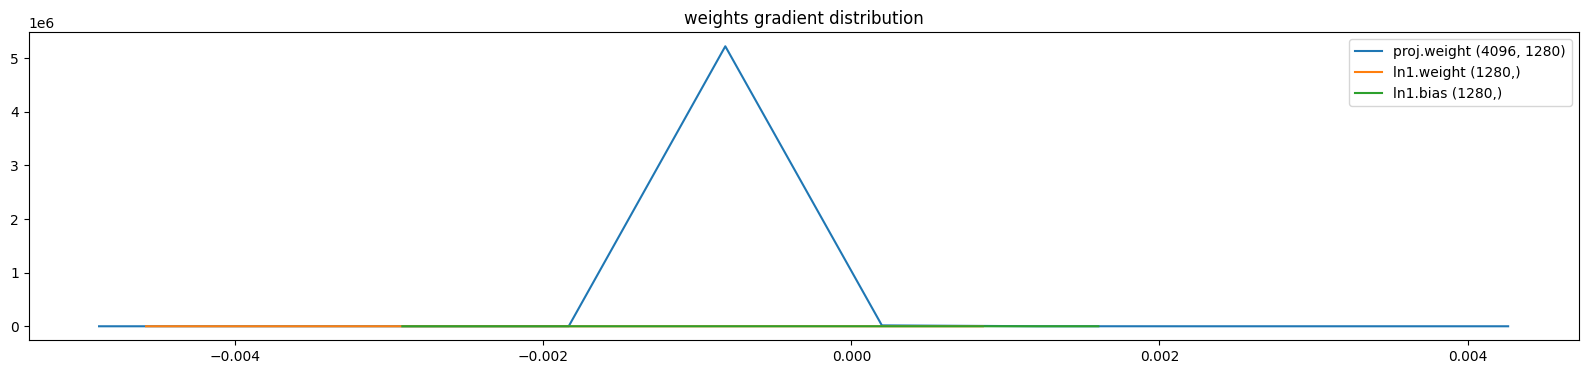

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
parameters = []
for i, l in enumerate([model.audio_encoder.proj]):
    #print('layer', l.__class__)
    for name, p in l.named_parameters():
        t = p.grad
        
        if t is None:
            continue

        print('layer %s | weight %10s | mean %+f | std %e | grad:data ratio %e' % (
            name, tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))

        hy, hx = np.histogram(t.to(torch.float32).cpu().detach().numpy())
        plt.plot(hx[:-1], hy)
        legends.append(f'{name} {tuple(p.shape)}')
            
plt.legend(legends)
plt.title('weights gradient distribution');

Text(0.5, 1.0, 'weight update relative to weight data, log scale')

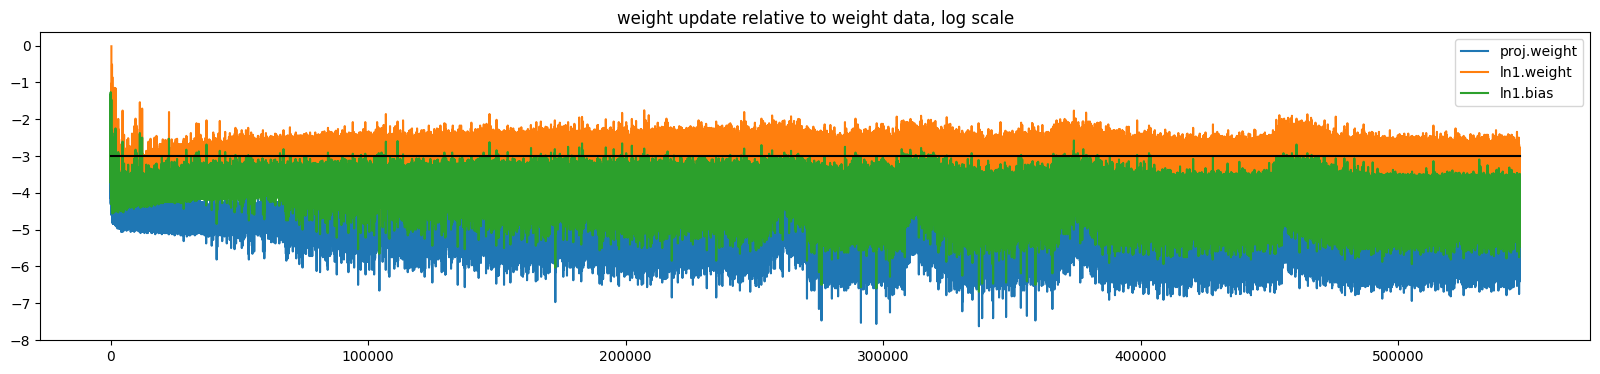

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
i = 0
for name, p in (model.audio_encoder.proj.named_parameters()):
    if p.grad is None:
        continue
    
    plt.plot([uds[epoch][i] for epoch in range(len(uds))])
    legends.append(name)

    i += 1
            
plt.plot([0, len(uds)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
plt.title("weight update relative to weight data, log scale")


In [ ]:
l = torch.tensor(losses)

In [ ]:
l[-50:].mean()

tensor(0.0640)

In [ ]:
ml = l[:547200].reshape(-1, 100).mean(axis=1)

(0.0, 2.0)

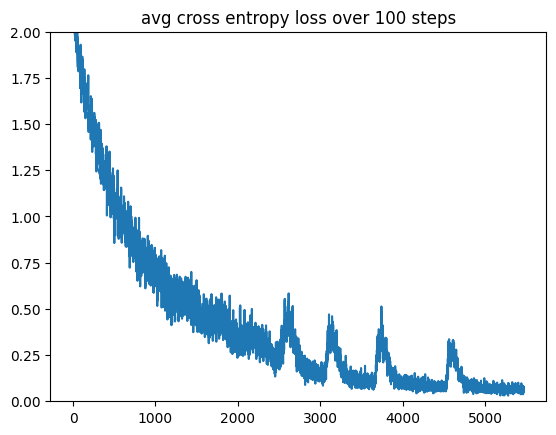

In [ ]:
plt.plot(range((ml.shape[0])), ml.numpy())
plt.title("avg cross entropy loss over 100 steps")
plt.ylim(0, 2)

In [ ]:
out = "/media/2nvme/proc/voixdb/model_manual_save3.pth"

torch.save(
    model.audio_encoder.proj.state_dict(),
    out,
)

In [ ]:
datagen=iter(eval_dl)

In [ ]:
local_batch = next(datagen)
audio_file = local_batch["_id"][0][0]
print(tokenizer.decode(local_batch["cap_ids"][0]))
Audio(audio_file)

This is a K-pop music piece performed by a boy band. Initially, a male vocalist is singing in a rap-like manner. Then, it switches to another male vocal that is singing more melodically. The melody is being played by a crisp synth sound. The rhythmic background consists of an energetic electronic drum beat. There is a danceable feel to it. This piece could be playing at Korean nightclubs and dance clubs.


In [ ]:
tokenizer.decode(sample_with_audio(model, tokenizer, prompt_template_fn(), audio_file, iteration=60)[0])

'<s> <|im_start|>  system\n    You are a helpful AI who follows instruction carefully<|im_end|> <|im_start|>  user\n    Describe the sound of the given file \n    <|im_end|> <|im_start|>  assistant\n     war<|im_end|> clockunits ]andfirst4Iftektime爆R Cur<|im_end|> United<|im_end|> ’daysIn“Never<|im_end|> thenAnd,and VI<|im_end|> Islo<|im_end|> GOkaydown<|im_end|> JainteYoulfailedLabelsEvenfacevC,rest<|im_end|><|im_end|><|im_end|><|im_end|> q<|im_end|> Xs<|im_end|> h<|im_end|><|im_end|>'

In [ ]:
import torch
import whisper

def prompt_template_fn(prompt="Describe the sound of the given file"):
    system_message = "You are a helpful AI who follows instruction carefully"

    prompt_prefix = f"""<|im_start|>system
    {system_message}<|im_end|>
    <|im_start|>user
    {prompt}"""

    return prompt_prefix


def end_template():
    return """
    <|im_end|>
    <|im_start|>assistant
    """


def load_audio_mels(file):
    audio = whisper.load_audio(file)
    audio = whisper.pad_or_trim(audio)
    audio_mels = whisper.log_mel_spectrogram(audio, n_mels=128)
    audio_mels = audio_mels.unsqueeze(0)
    return audio_mels


def text_2_ids_and_attention_mask(tokenizer, input_txt, truncate=False):
    txt = input_txt
    res = tokenizer(txt, return_tensors="pt")

    if truncate:
        return res.input_ids[:, 1:], res.attention_mask[:, 1:]

    return res.input_ids, res.attention_mask

@torch.no_grad()
def sample_with_audio(model, tokenizer, prompt, audio_file, device="cuda:0", iteration=50):
    audio_mels = load_audio_mels(audio_file).to(device).half()
    end_prompt_ids, end_prompt_attention_mask = text_2_ids_and_attention_mask(
        tokenizer,
        end_template(),
        truncate=True,
    )
    prompt_ids, prompt_attention_mask = text_2_ids_and_attention_mask(
        tokenizer,
        prompt,
    )

    prompt_ids = prompt_ids.to(device)
    prompt_attention_mask = prompt_attention_mask.to(device)
    end_prompt_attention_mask = end_prompt_attention_mask.to(device)
    end_prompt_ids = end_prompt_ids.to(device)
    sampled_ids = None

    prompt_embeds = None
    end_prompt_embeds = None
    audio_embeds = None

    with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
        if audio_embeds is None:
            audio_embeds = model.audio_encoder(audio_mels)
        bs, audio_seq = audio_embeds.shape[:2]
        
        mask_concat_args = [
            prompt_attention_mask,
            torch.ones(bs, audio_seq).to(audio_embeds.device),
            end_prompt_attention_mask,
        ]

        for _ in range(iteration):
            if sampled_ids is not None:
                mask_concat_args.append(torch.ones(bs, sampled_ids.shape[1]).to(audio_embeds.device))
                
            attention_mask = torch.concat(
                tuple(mask_concat_args),
                dim=1,
            )

            if prompt_embeds is None:
                prompt_embeds = model.llm.model.embed_tokens(prompt_ids)
            if end_prompt_embeds is None:
                end_prompt_embeds = model.llm.model.embed_tokens(end_prompt_ids)
                
            sampled_ids_embeds = None
            if sampled_ids is not None:
                sampled_ids_embeds = model.llm.model.embed_tokens(sampled_ids)
                
            embeds_concat_args = [
                prompt_embeds,
                audio_embeds.to(prompt_embeds.dtype),
                end_prompt_embeds,
            ]
            if sampled_ids_embeds is not None:
                embeds_concat_args.append(sampled_ids_embeds)
                
            inputs_embeds = torch.concat(
                tuple(embeds_concat_args),
                dim=1,
            )
    
            mout = model.llm(
                inputs_embeds=inputs_embeds,
                attention_mask=attention_mask,
            )
    
            logits = mout.logits
            sampled = torch.multinomial(logits[:, -1, :].softmax(dim=-1), 1)
            
            if sampled_ids is None:
                sampled_ids = sampled
            else:
                sampled_ids = torch.cat((sampled_ids, sampled), dim=-1).to(device)

    # print(prompt_ids.shape)
    # print(end_prompt_ids.shape)
    # print(sampled_ids.shape)
    
    return torch.concat((
        prompt_ids, 
        end_prompt_ids,
        sampled_ids,
    ),dim=-1)
